# Restaurant Reviews - NLP

In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# For text cleaning
import re # Regular expression library 
import nltk # Natural Language Toolkit

In [2]:
# Importing the dataset
dataset = pd.read_csv('Restaurant_Reviews.tsv', delimiter = '\t', quoting = 3)
dataset.shape

(1000, 2)

In [3]:
dataset.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## Cleaning the text

Because we will be making a sparse matrix we will need to remove any words not contributing to the
review's positive or negative state. 


We will do this by:
1. Removing stop words -  commonly used word (such as "the")
2. Stemming            - The process of reducing inflected words to their root form (such as loved to love)

In [4]:
# download the stopwords list from nltk
nltk.download('stopwords') 
# import the downloaded stopwords
from nltk.corpus import stopwords
# PortStemmer is used for stemming
from nltk.stem.porter import PorterStemmer 

corpus = []
for i in range(0, len(dataset)):
    # remove everything but a-zA-Z and replace anything removed with a ' '
    review = re.sub('[^a-zA-Z]', ' ', dataset['Review'][i]) 
    review = review.lower()
    review = review.split() # split review into list of words
    ps = PorterStemmer()
    # remove list of english words not relevant to review. Stopwords contains lists of different languages, must specify English
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))] # sets are faster than lists for big sentences
    review = ' '.join(review) # go back to a string for each review
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gega_PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# let's take a look at what this has done to our top 5 reviews:
corpus[0:5]

['wow love place',
 'crust good',
 'tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

We can see that we still have names in our reviews like 'rick steve'. These will cause our sparse matrix later on to be needlessly large. 

We can constrain the maximum features of our matrix and since names aren't as common as other words these can be removed.


In [6]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 1500) # create object of the CountVectorizer class
X = cv.fit_transform(corpus).toarray() # tokenisation, need toarray() to crate the matirx
y = dataset.iloc[:, 1].values # Get our dependant variable from 'dataset' 

NOTE: because all our values are either 1 or 0 there is not need for feature scaling here

In [7]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

## Model Selection

Now we have our data ready which model do we use?

I will try all classification models I know and look at the accuracy of each:

In [8]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [12]:
# prepare models
models = []
models.append(('LR', LogisticRegression(random_state = 0))) 
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(criterion = 'entropy')))
models.append(('RNDFRST', RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel = 'rbf')))

In [20]:
# Making the Confusion Matrix for each and evaluating accuracy
from sklearn.metrics import confusion_matrix

# evaluate each model in turn
for name, classifier in models:
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = (cm[0][0]+cm[1][1])/200
    msg = '{} : {}'.format(name,  str(acc))
    print(msg)

LR : 0.71
KNN : 0.61
CART : 0.69
RNDFRST : 0.72
NB : 0.73
SVM : 0.485


Naive Bayes offers the highest accuracy

In [29]:
# Fitting Naive Bayes to the Training set
classifier = GaussianNB()
classifier.fit(X_train, y_train)

GaussianNB(priors=None)

In [33]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# pd.DataFrame(y_pred).head()

In [34]:
# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[55, 42],
       [12, 91]], dtype=int64)

In [27]:
# # evaluate each model in turn using K-Fold Cross Validation
# results = []
# names = []
# scoring = 'accuracy'
# for name, model in models:
#     kfold = model_selection.KFold(n_splits=10, random_state=10) 
#     cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

LR: 0.773000 (0.044283)
KNN: 0.672000 (0.035157)
CART: 0.727000 (0.036892)
RNDFRST: 0.749000 (0.054489)
NB: 0.719000 (0.051274)
SVM: 0.396000 (0.120516)


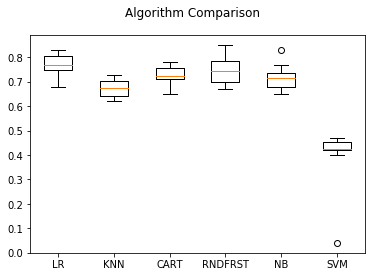

In [28]:
# # boxplot algorithm comparison
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()